# Investigating KwaDela: May 2016 Analysis
-----------------------------------------------------

### Data Science 2016 Final Project
Mackenzie Frackleton

Brenna Manning

Olin College of Engineering

#### Initial Proposal
The key ideas of this project are to work with an external collaborator to understand a data set. We are also looking to work with a time course data series in this project; we need to find the best way to examine data in a temporal dimension and not misrepresent with values that gather multi-week spanning data into one misleading value (non meaningful means for example). We’ve both also done a fair bit of work with data visualization and are looking to enhance the experience by finding effective techniques for representing data across time. We’re hoping we can look at existing journal articles and other peer-reviewed documents for inspiration on appropriate visualization techniques. We haven’t used much of what we have discussed in Thinkstats2 in projects yet, so we are now looking to apply these statistics techniques for comparing time course datasets (we do not yet know what these conventions are) to our data-heavy project. The MVP for this project would be well documented code with visualizations to make data relationships more clear in order to further data analysis.

### Imports, loading and cleaning data, defining functions to be used later.

In [31]:
#IMPORTS
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
sns.set_context("poster")
import numpy as np
import pprint as pp
from IPython.display import display
import scipy.stats as stats

#LOAD DATA FROM CSVs FROM CSVBUILDER
df2013 = pd.read_csv('Kwadela_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadela_winter_2014_cleaned.csv')

print df2013.head()

   Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
0           0                NaN           NaN            NaN        NaN   
1           1                NaN           NaN            NaN        NaN   
2           2                NaN           NaN            NaN        NaN   
3           3                NaN           NaN            NaN        NaN   
4           4                NaN           NaN            NaN        NaN   

   CO_(ppm)  NO_(ppb)  NO2_(ppb)          Date  Temperature_(degC)   ...     \
0       NaN       NaN        NaN  7/2/13 12:00                 NaN   ...      
1       NaN       NaN        NaN  7/2/13 12:01                 NaN   ...      
2       NaN       NaN        NaN  7/2/13 12:02                 NaN   ...      
3       NaN       NaN        NaN  7/2/13 12:03                 NaN   ...      
4       NaN       NaN        NaN  7/2/13 12:04                 NaN   ...      

   H05-K-N  H06-K-N  H07-K-S  H10-K-N  H11-K-X  H12-K-N  H15-K-S  H1

#### Helper Functions

In [93]:
#SOME HELPER FUNCTIONS


def get_datetime(s):
    """strips date and time from the already existing date column"""
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def daysSinceStart(df):
    """get time since epoch using a series for month and day
    takes in dataframe and returns the dataframe with an added column
    for days since the beginning of data collection"""
    
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
            #do nothing, append the normal day
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        #print'tot days:', total_days, month, day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df


#Daily Average Temperature

def compute_avg_vals(df):
    """computes average values of each day in a dataframe
    must apply to a groupby object where df is grouped by days
    returns a dataframe with several new, added columns """
    
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    df['DailyAverageTempHouse'] = df['AvgHouse'].mean()
    #computes avg indoor temp: takes in a dataframe and returns a dataframe with a new column
    #Removed: df['H07-K-S'].mean() because it's mostly just Nans
    #df['AvgHouse'] = (df['H01-K-E'].mean()+ df['H02-K-N'].mean() + df['H03-K-S'].mean()+ df['H04-K-S'].mean())/4
    #df['DailyAvgHouse']= df['AvgHouse'].mean()
    #Dusttraks/PM4
    df['DailyAvgDusttraks'] = df['Dusttraks_(mg/m3)'].mean()
    df['DailyAvgPM4'] = df['PM4_(ug/m3)'].mean()
    df['DailyAvgWind'] = df['Wind_Speed_(m/s)'].mean()
    return df

def compute_avg_house13(df):
    """tailored to compute the average indoor house temperature of 2013"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-X']+ df['H12-K-N'] + df['H15-K-S'] +df['H17-K-N'] 
                      + df['H18-K-S'] + df['H20-K-S']
                      )/13
    return df

def compute_avg_house14(df):
    """tailored to compute the avg indoor house temp for 2014"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-N'] + df['H15-K-N']+df['H16-K-N'] +df['H17-K-S'] 
                      + df['H18-K-N']+df['H19-K-W'] + df['H22-K-S']
                      )/14
    return df

def tempdifference(df):
    """computes a column of the difference in indoor and outdoor temperature, AvgHouse and Temperature_(degC)
    df: any given dataframe
    returns a dataframe with a new column"""
    df['tempdifference'] = df['AvgHouse']-df['Temperature_(degC)']
    return df


def abcdeTimeDataframes(df):
    """splits a dataframe into a series of times for differently characterized burning periods of the day
    df: timeseries dataframe to be split into specified time ranges
    returns: 4 different dataframes for early morning, breakfast, afternoon, dinner, and evening times
    """
    #DATAFRAMES FOR GIVEN TIME RANGES
    dfA = df[df['Hour'] < 5]
    dfB = df[df['Hour'] > 4]
    dfB = dfB[dfB['Hour'] <= 9]
    dfC = df[df['Hour'] >9]
    dfC = dfC[dfC['Hour'] <= 14]
    dfD = df[df['Hour'] >14]
    dfD = dfD[dfD['Hour'] <= 21]
    dfE = df[df['Hour'] > 21]
    res = [dfA, dfB, dfC, dfD, dfE]
    return res


#GENERAL FUNCTION FOR DIURNAL DATA

def getmeanfeatureforhour(hourdf, feature):
    """hourdf: dataframe specific to one hour of data
    feature: given header to be explored (temperature, PMx, etc)
    returns: dataframe with a new mean feature per hour"""
    
    res = hourdf[feature].mean()
    return res

def featurediurnaldata(df, feature):
    """breaks down a given dataframe by feature into one dataframe per hour (24) for plotting of a dirunal profile
    df: dataframe to be broken down
    feature: header to be broken down"""
    #feature for example could be a temperature or pollutant concentration
    dfhour0 = df[df['Hour'] == 0]
    feat0 = getmeanfeatureforhour(dfhour0, feature)
    dfhour1 = df[df['Hour'] == 1]
    feat1= getmeanfeatureforhour(dfhour1, feature)
    dfhour2 = df[df['Hour'] == 2]
    feat2 = getmeanfeatureforhour(dfhour2, feature)
    dfhour3 = df[df['Hour'] == 3]
    feat3 = getmeanfeatureforhour(dfhour3, feature)
    dfhour4 = df[df['Hour'] == 4]
    feat4 = getmeanfeatureforhour(dfhour4, feature)
    dfhour5 = df[df['Hour'] == 5]
    feat5 = getmeanfeatureforhour(dfhour5, feature)
    dfhour6 = df[df['Hour'] == 6]
    feat6 = getmeanfeatureforhour(dfhour6, feature)
    dfhour7 = df[df['Hour'] == 7]
    feat7 = getmeanfeatureforhour(dfhour7, feature)
    dfhour8 = df[df['Hour'] == 8]
    feat8 = getmeanfeatureforhour(dfhour8, feature)
    dfhour9 = df[df['Hour'] == 9]
    feat9 = getmeanfeatureforhour(dfhour9, feature)
    dfhour10 = df[df['Hour'] == 10]
    feat10 = getmeanfeatureforhour(dfhour10, feature)
    dfhour11 = df[df['Hour'] == 11]
    feat11 = getmeanfeatureforhour(dfhour11, feature)
    dfhour12 = df[df['Hour'] == 12]
    feat12 = getmeanfeatureforhour(dfhour12, feature)
    dfhour13 = df[df['Hour'] == 13]
    feat13 = getmeanfeatureforhour(dfhour13, feature)
    dfhour14 = df[df['Hour'] == 14]
    feat14 = getmeanfeatureforhour(dfhour14, feature)
    dfhour15 = df[df['Hour'] == 15]
    feat15 = getmeanfeatureforhour(dfhour15, feature)
    dfhour16 = df[df['Hour'] == 16]
    feat16 = getmeanfeatureforhour(dfhour16, feature)
    dfhour17 = df[df['Hour'] == 17]
    feat17 = getmeanfeatureforhour(dfhour17, feature)
    dfhour18 = df[df['Hour'] == 18]
    feat18 = getmeanfeatureforhour(dfhour18, feature)
    dfhour19 = df[df['Hour'] == 19]
    feat19 = getmeanfeatureforhour(dfhour19, feature)
    dfhour20 = df[df['Hour'] == 20]
    feat20 = getmeanfeatureforhour(dfhour20, feature)
    dfhour21 = df[df['Hour'] == 21]
    feat21 = getmeanfeatureforhour(dfhour21, feature)
    dfhour22 = df[df['Hour'] == 22]
    feat22 = getmeanfeatureforhour(dfhour22, feature)
    dfhour23 = df[df['Hour'] == 23]
    feat23 = getmeanfeatureforhour(dfhour23, feature)

    featlist = [feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23]
    return featlist



def preprocess(df):
    """get all mean features and recodes for plotting and stats analysis
    apply correction factor and unit tweaking where appropriate
    returns: a copy of the original df with added hour, day,month, year, daycount
    tempdifferent, and PM4 counts"""

    res = df.copy()
    if hasattr(res, 'Date'):
        datetimes = res.Date.apply(get_datetime)
        res['Hour'] = datetimes.apply(lambda dt: dt.hour)
        res['Day'] = datetimes.apply(lambda dt: dt.day)
        res['Month'] = datetimes.apply(lambda dt: dt.month)
        res['Year'] = datetimes.apply(lambda dt: dt.year)
    res = daysSinceStart(res)
    res['Dusttraks_(mg/m3)']= res['Dusttraks_(mg/m3)']*0.14
    res['PM4_(ug/m3)']=res['Dusttraks_(mg/m3)']*1000
    grouped = res.groupby('DayCount')
    res = grouped.apply(compute_avg_vals)
    res= tempdifference(res)
    return res




### Preprocess our dataframes
##### Get Hour, Day, Month, Year from Date object, apply Dusttraks correction factor, and create PM4 column with same units as PM2.5 & PM10


In [94]:
#PREPROCESS OUR DATAFRAMES
df2013 = compute_avg_house13(df2013) # this is necessary outside preprocess because the two years have different house label
df2013 = preprocess(df2013)


df2014 = compute_avg_house14(df2014)
df2014 = preprocess(df2014)

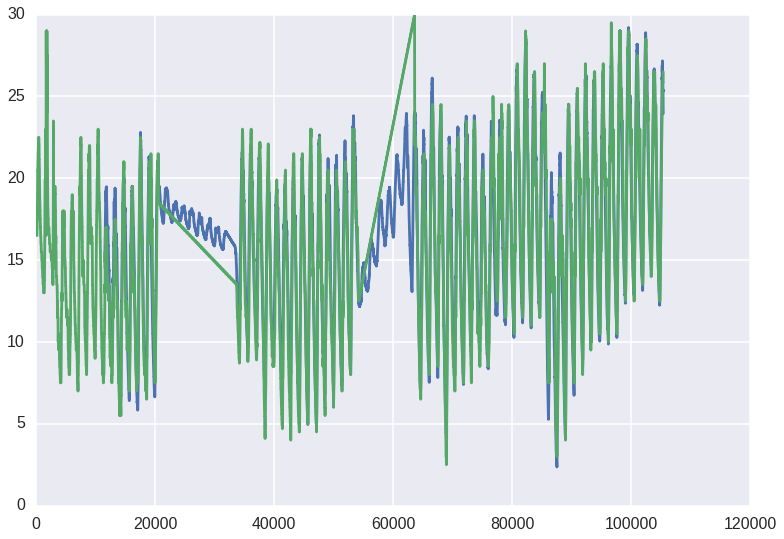

In [34]:
plt.plot(df2013.AvgHouse)
plt.plot(df2013['H02-K-N'])

## First, we will examine just the 2013 data

### Data Over Entire Winter

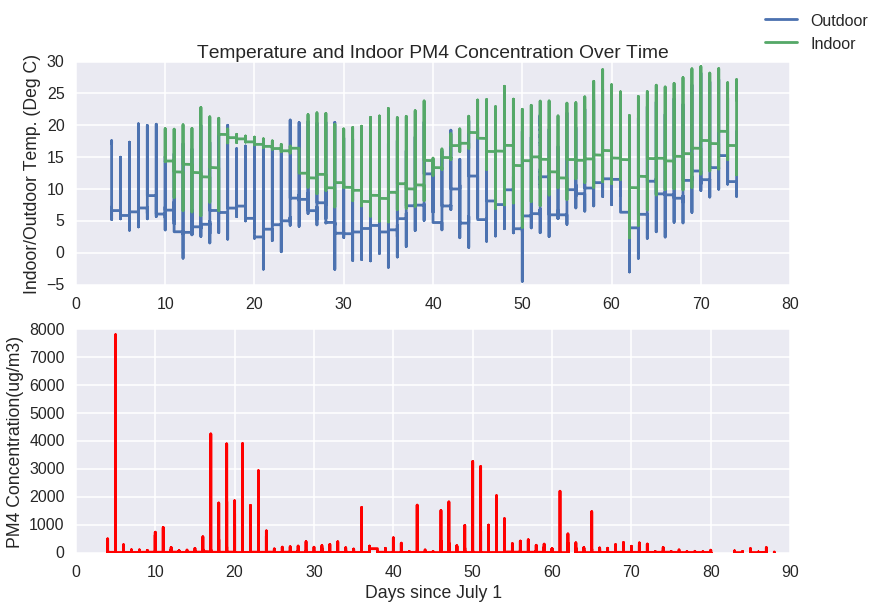

In [35]:
plt.figure(1)
plt.subplot(211)
plt.title('Temperature and Indoor PM4 Concentration Over Time')
plt.plot(df2013['DayCount'], df2013['Temperature_(degC)'])
plt.plot(df2013['DayCount'], df2013['AvgHouse'])
plt.ylabel('Indoor/Outdoor Temp. (Deg C)')
plt.legend(['Outdoor', 'Indoor'],bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)

plt.subplot(212)
plt.plot(df2013['DayCount'], df2013['PM4_(ug/m3)'], '-r')
plt.xlabel('Days since July 1')
plt.ylabel('PM4 Concentration(ug/m3)')
plt.show()

This visualizations above are noisy and unclear.This is because many of the trends we're looking at are periodic with a period of 24 hours (or 1 day). By taking the average temperature/concentration of each day of the winter and plotting that, we can see the trends over the course of the winter and get rid of daily periodic fluctuations.

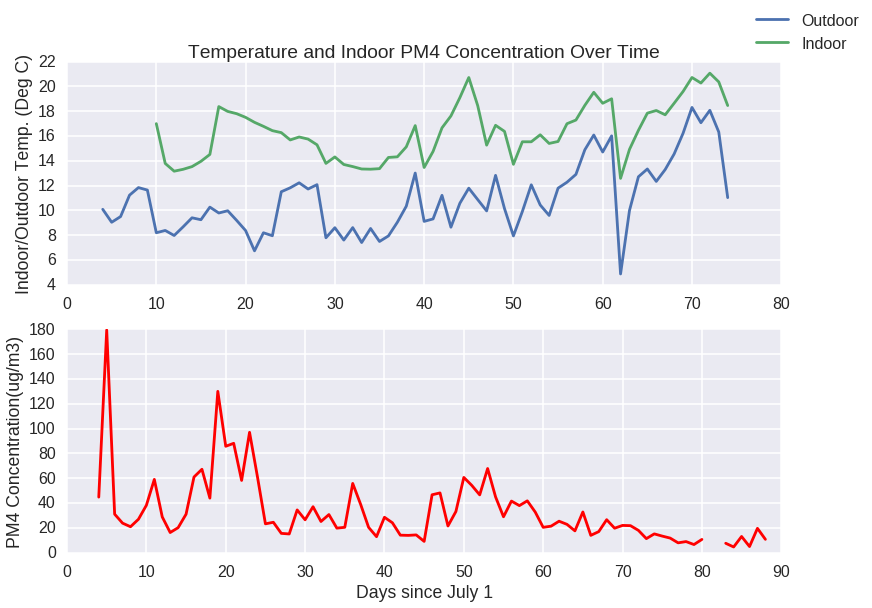

In [36]:
#By Daily Averages
plt.figure(1)

plt.subplot(211)
plt.title('Temperature and Indoor PM4 Concentration Over Time')
plt.plot(df2013['DayCount'], df2013['DailyAverageTemp'])
plt.plot(df2013['DayCount'], df2013['DailyAverageTempHouse'])
plt.ylabel('Indoor/Outdoor Temp. (Deg C)')
plt.legend(['Outdoor','Indoor'],bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)

plt.subplot(212)
plt.plot(df2013['DayCount'], df2013['DailyAvgPM4'], '-r')
plt.xlabel('Days since July 1')
plt.ylabel('PM4 Concentration(ug/m3)')
plt.show()

### Diurnal Profiles of the Data
Because the pollution is coming from coal burning within homes, which is influenced by daily routines, we see more meaningful trends when we examine this data on a daily basis (what an average day looks like). Diurnal profiles examine the periodic trends we smoothed out in our previous graphs, and recover more meaningful data that was lost in smoothing. The following graphs examine trends in average temperatures and pollutant concentrations.

In [37]:
#0-23 Hours of the day to use as x-axis for diurnal visualizations.
hourlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

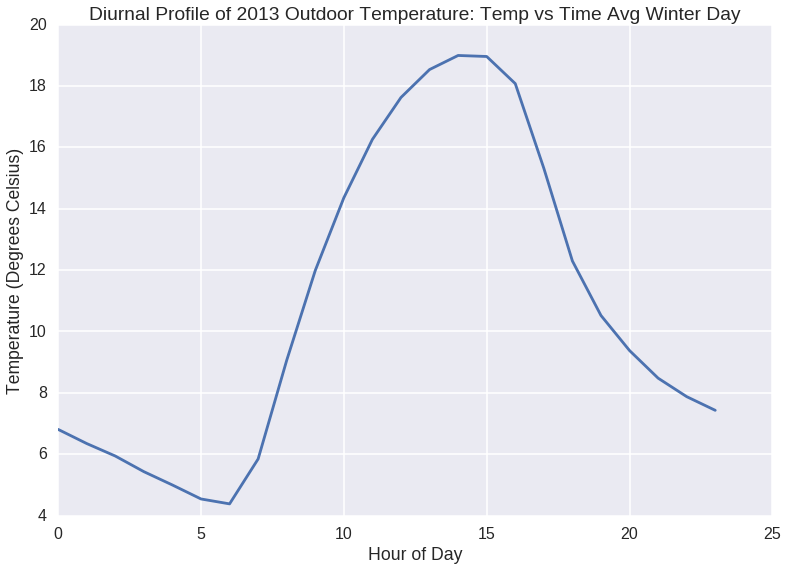

In [38]:
plt.plot(hourlist, featurediurnaldata(df2013, 'Temperature_(degC)'))
plt.title('Diurnal Profile of 2013 Outdoor Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()

Below is average indoor temperature across all houses's kitchen sensors.(This recoding is done in the compute_avg_house functions)

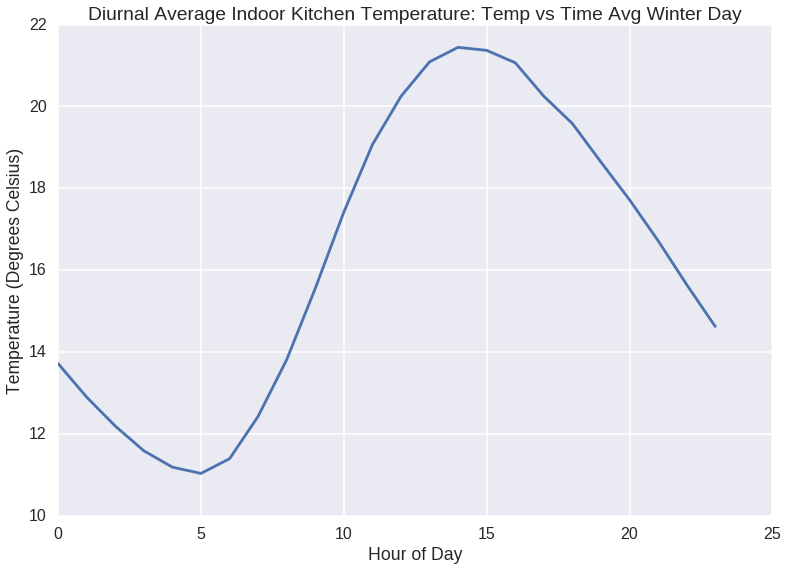

In [39]:
plt.plot(hourlist, featurediurnaldata(df2013, 'AvgHouse'))
plt.title('Diurnal Average Indoor Kitchen Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()

We now look at the derivative of the difference between indoor and outdoor temperature over the course of a day. This helps track when burning actually happened and removes the temperature outside as a source of heat for the interior of the house

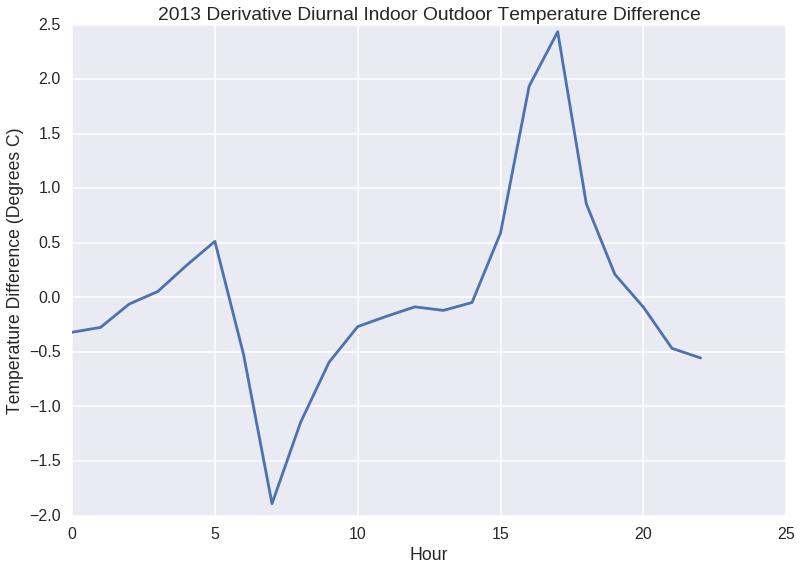

In [40]:
hourlist23 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013, 'tempdifference')))
plt.title('2013 Derivative Diurnal Indoor Outdoor Temperature Difference')
plt.ylabel('Temperature Difference (Degrees C)')
plt.xlabel('Hour')
plt.show()

Here's the temperature difference, for reference to the derivative graph. This tells us less valuable information than the above derivative graph, but it's good to understand what the slopes look like and how we came to create the derivative

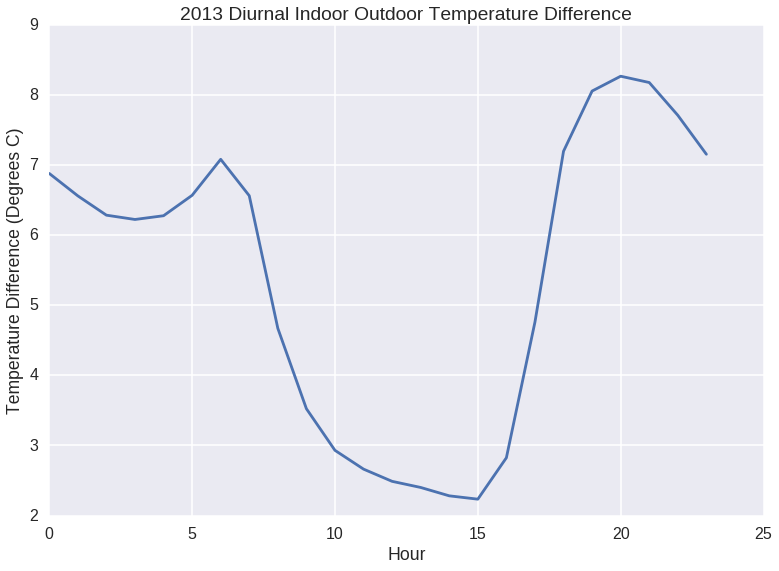

In [41]:
plt.plot(hourlist, featurediurnaldata(df2013, 'tempdifference'))
plt.title('2013 Diurnal Indoor Outdoor Temperature Difference')
plt.ylabel('Temperature Difference (Degrees C)')
plt.xlabel('Hour')
plt.show()

The PM4 concentration is the concentration of all pollutant particulate matter of 4 microns or less that is found indoors. These particles are particularly harmful to human health because they are small enough to flow into the respiratory tract and causes lung problems. They're also measurements taken exclusively indoors, and are caused only by indoor pollution sources, AKA burning coal. 

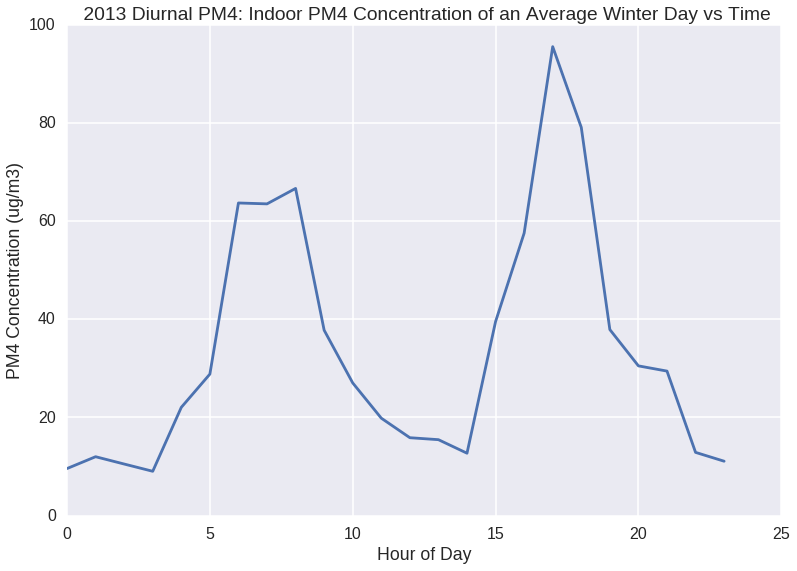

In [42]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM4_(ug/m3)'))
plt.title(' 2013 Diurnal PM4: Indoor PM4 Concentration of an Average Winter Day vs Time')
plt.xlabel('Hour of Day')
plt.ylabel('PM4 Concentration (ug/m3)')
plt.show()

PM10 concentration is the concentration of all pollutant particles less than 10 microns in diameter but greater than 2.5 microns; this measurement was also taken exclusively outside. This pollution can be caused by coal burning and also can be carried in by wind and other large weather patterns. It is also damaging to human health

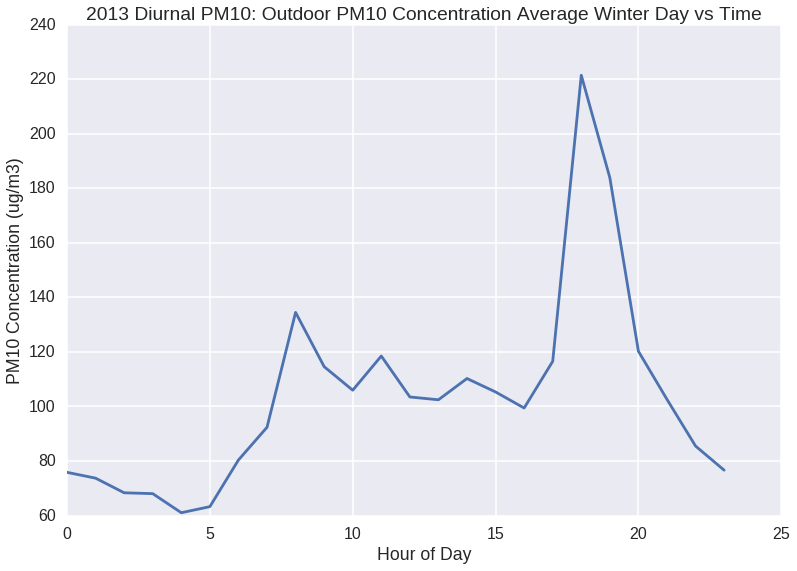

In [43]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM10_(ug/m3)'))
plt.title('2013 Diurnal PM10: Outdoor PM10 Concentration Average Winter Day vs Time')
plt.xlabel('Hour of Day')
plt.ylabel('PM10 Concentration (ug/m3)')
plt.show()

In a similar naming convention to other PM's PM2.5 is pollutant particles less than 2.5 microns in diameter. It is the smallest in size of the particulate pollutants and is therefore the most threatening to human health, as it deposits most easily in the lungs. PM2.5 was also measured exclusively outdoors

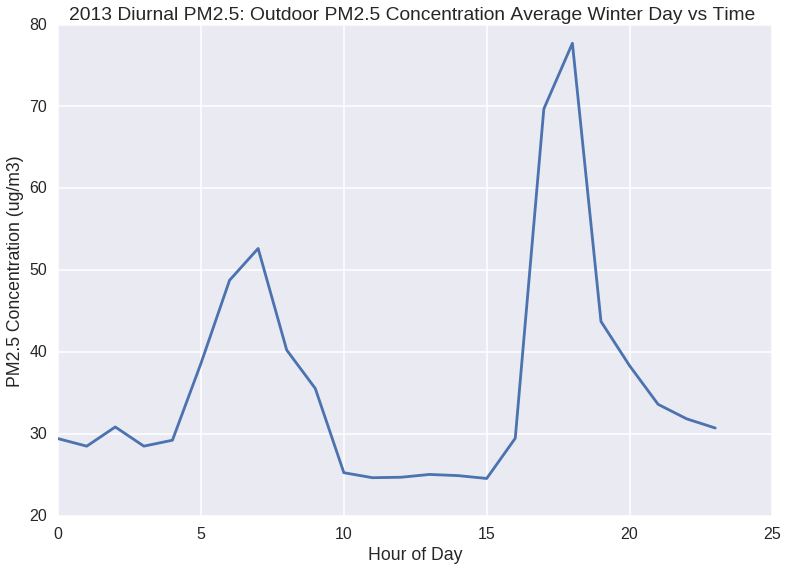

In [44]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM2.5_(ug/m3)'))
plt.title('2013 Diurnal PM2.5: Outdoor PM2.5 Concentration Average Winter Day vs Time ')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.show()

CO, or corbon monoxide, is known as a "tracer pollutant" because it is a direct result of coal burning. CO is damaging to human health and is known in literature to correlate highly to burning of coal. Unfortunately, the CO data for 2013 was subject to error upon collection and could not be used accurately. Below is a graph of the 2014 data which has the same shape the 2013 data would have had, given it was correctly collected.

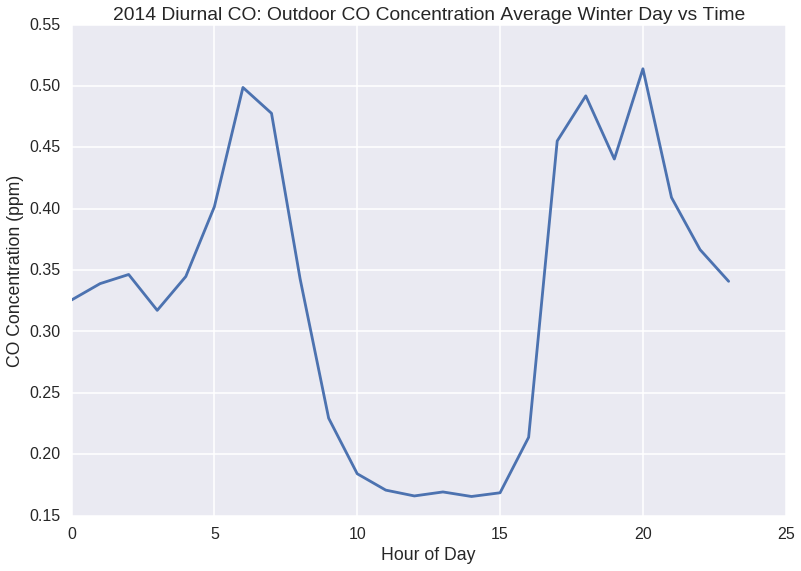

In [45]:
plt.plot(hourlist, featurediurnaldata(df2014, 'CO_(ppm)'))
plt.title('2014 Diurnal CO: Outdoor CO Concentration Average Winter Day vs Time')
plt.xlabel('Hour of Day')
plt.ylabel('CO Concentration (ppm)')
plt.show()

Every day has evident patterns. The later afternoon is the warmest portion of the day outdoors, and as the evening turns to night the interior of the house is warmed by the coal stove used to make a cooking fire. Pollutants spike in the morning and evening, indicating use of the stove for a combination of warmth and cooking. We know morning stove use is usually exclusively for heating the home after a cold night (people often wake just after midnight to stoke the fire) and for heathing water. In the evenings, residents of KwaDela use their stoves to cook dinner and keep the family warm for the night. The stove is used most heavily for dinnertime. 

## Compare 2013 & 2014 Data
### Pre Vs Post Intervention

For the winter of 2014, several interventions were put into place to retain heat in several homes and to reduce coal burning. The following section explores what effect the intervention had, and how data from the two winters compare. 

#### Over Entire Winter
The below set of graphs compares indoor and outdoor temperatures, as well as the PM4 concentrations. We see that 2014 is generally a little bit warmer than 2013, and it's significantly warmer indoors, indicating the intervention may have succeeded in making the homes warmer.

The PM4 data for 2014 looks a little bit off, so we look at some diurnal profiles to investigate furthur.

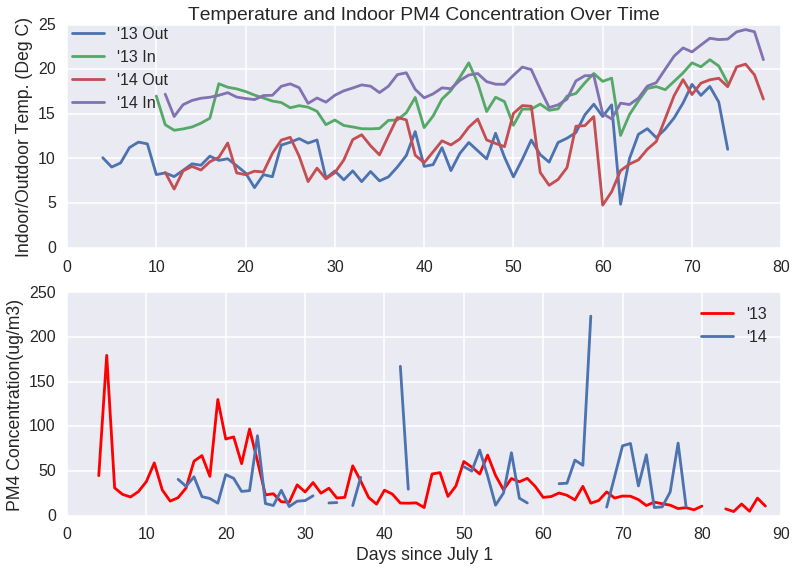

In [46]:
plt.figure(1)

plt.subplot(211)
plt.title('Temperature and Indoor PM4 Concentration Over Time')
plt.plot(df2013['DayCount'], df2013['DailyAverageTemp'])
plt.plot(df2013['DayCount'], df2013['DailyAverageTempHouse'])
plt.plot(df2014['DayCount'], df2014['DailyAverageTemp'])
plt.plot(df2014['DayCount'], df2014['DailyAverageTempHouse'])
plt.legend(['\'13 Out','\'13 In', '\'14 Out', '\'14 In'],bbox_to_anchor=(0.25, 0.92),
           bbox_transform=plt.gcf().transFigure)

plt.ylabel('Indoor/Outdoor Temp. (Deg C)')

plt.subplot(212)
plt.plot(df2013['DayCount'], df2013['DailyAvgPM4'], '-r')
plt.plot(df2014['DayCount'], df2014['DailyAvgPM4'])
plt.legend(['\'13', '\'14'])
plt.xlabel('Days since July 1')
plt.ylabel('PM4 Concentration(ug/m3)')

#### Diurnal Profiles

Each day in 2014 followed the same temperature trends as in 2013, but 2014 was generally warmer. We illustrate this  in each graph that deals with temperature comparisons below

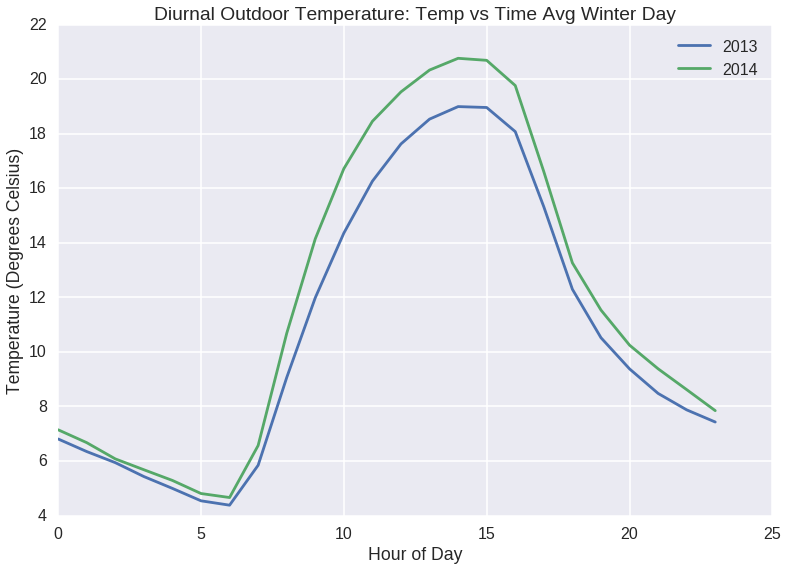

In [47]:
plt.plot(hourlist, featurediurnaldata(df2013, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'Temperature_(degC)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal Outdoor Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()

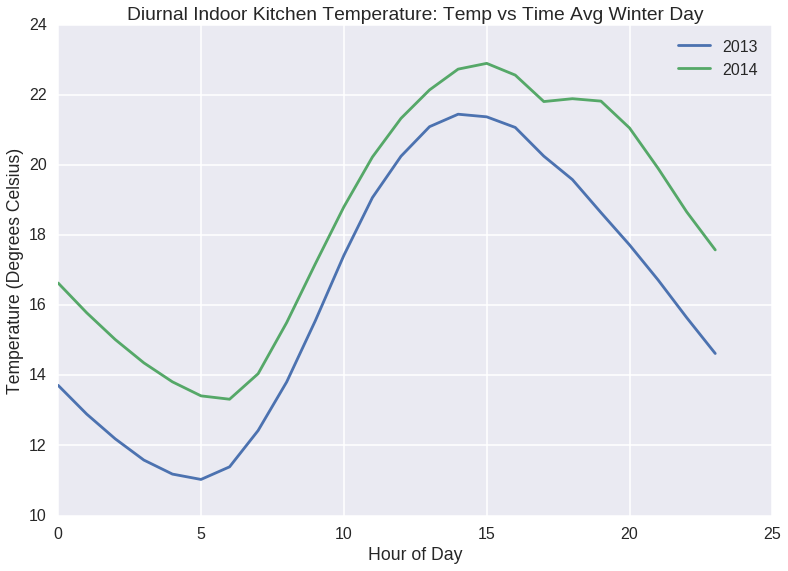

In [48]:
plt.plot(hourlist, featurediurnaldata(df2013, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2014, 'AvgHouse'))

plt.legend(['2013', '2014'])
plt.title('Diurnal Indoor Kitchen Temperature: Temp vs Time Avg Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (Degrees Celsius)')
plt.show()


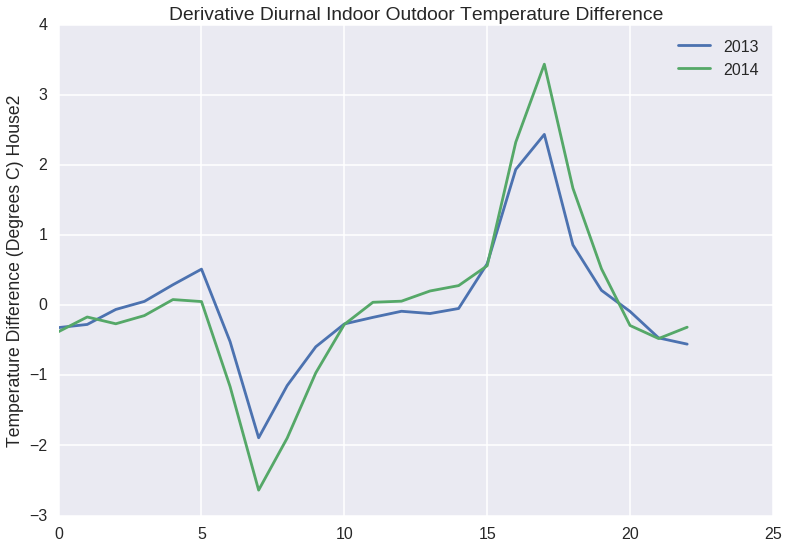

In [49]:
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013, 'tempdifference')))
plt.plot(hourlist23, np.diff(featurediurnaldata(df2014, 'tempdifference')))
plt.title('Derivative Diurnal Indoor Outdoor Temperature Difference')
plt.legend(['2013', '2014'])
plt.ylabel('Temperature Difference (Degrees C) House2')
plt.show()

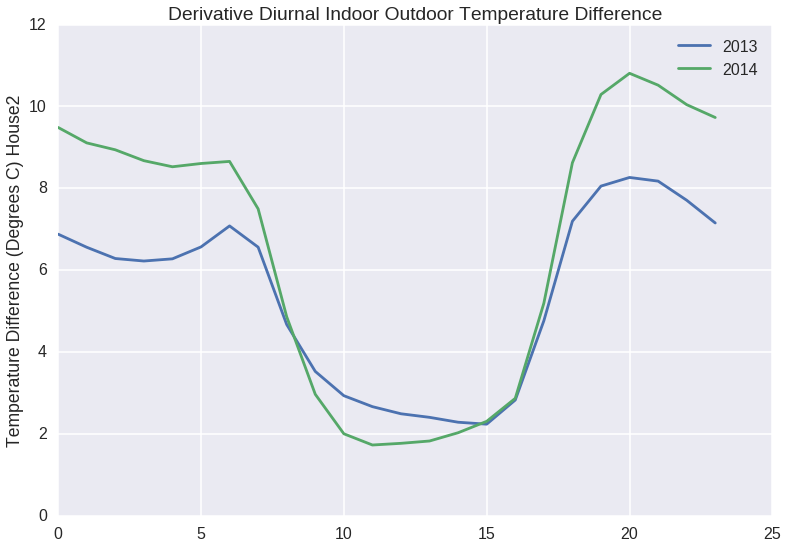

In [50]:
plt.plot(hourlist, featurediurnaldata(df2013, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014, 'tempdifference'))
plt.title('Derivative Diurnal Indoor Outdoor Temperature Difference')
plt.legend(['2013', '2014'])
plt.ylabel('Temperature Difference (Degrees C) House2')
plt.show()

It looks like PM4 increases in 2014, which is worth more investigation later on. The outdoor pollutants otherwise decrease in 2014, especially at times of peak stove use. This suggests less coal burning happened in 2014 (maybe the intervention was successful) 

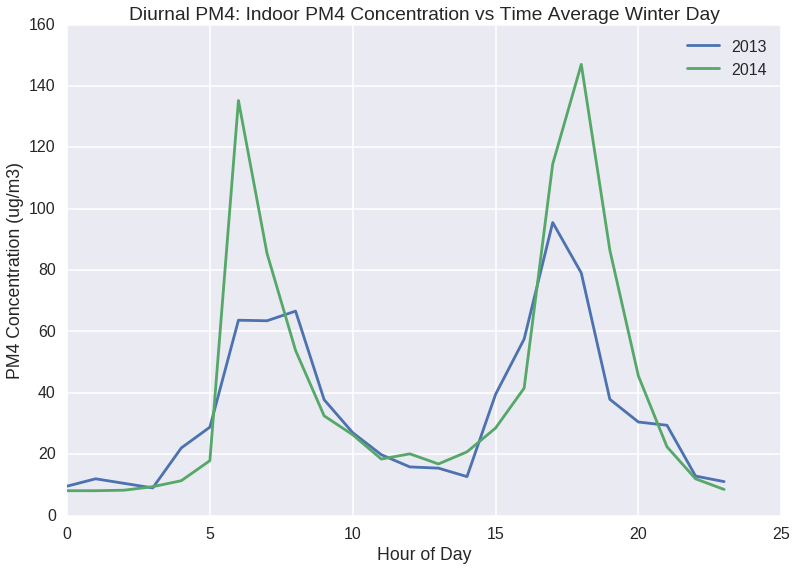

In [51]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'PM4_(ug/m3)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal PM4: Indoor PM4 Concentration vs Time Average Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('PM4 Concentration (ug/m3)')
plt.show()

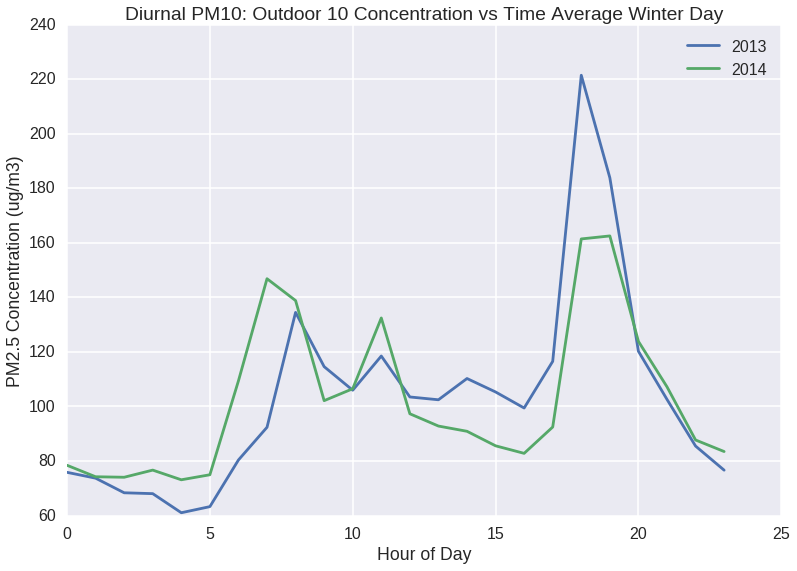

In [52]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'PM10_(ug/m3)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal PM10: Outdoor 10 Concentration vs Time Average Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.show()

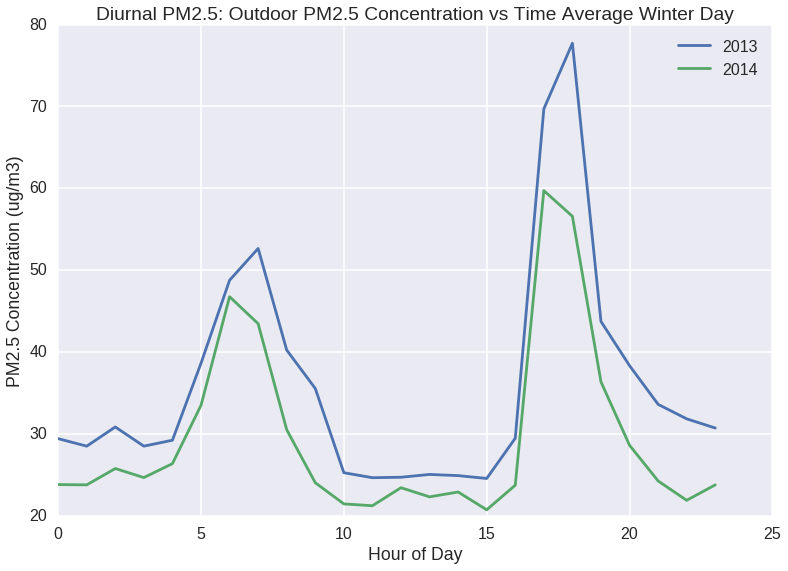

In [53]:
plt.plot(hourlist, featurediurnaldata(df2013, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014, 'PM2.5_(ug/m3)'))
plt.legend(['2013', '2014'])
plt.title('Diurnal PM2.5: Outdoor PM2.5 Concentration vs Time Average Winter Day')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (ug/m3)')
plt.show()

Unfortunately, lack of accurate CO readings leave us unable to compare CO pollutants. This information would have been extremely valuable, and can hopefully be collected for future studies to compare.

### Separate days into temperature brackets: warm, medium, and cold days.

We need a more meaningful way to compare 2013 and 2014, so we're making three temperature brackets. Comparing an "average day" minimalizes the importance of cold days where large amounts of coal were burned, so it's not that significant. We want to set cutoff temperatures for these brackets so 2013 and 2014 can be broken down into like chunks. 

To find these cutoff temperatures, we find the IQR brackets of outdoor temperature for each year, and use the quartile cutoff temperatures of the warmer year, so that both have at least 25% of their days counted as cold days.

2014 is the warmer year, so cold days are defined as days in either 2013 or 2014 where the average temperature of that day is colder than 25% of days in 2014.

In [54]:
def cutoffGen(df):
    """takes: a dataframe with 'DailyAverageTemp' to create a bracket cutoff temperature
    returns: a cold (Q1) and warm (Q3) cutoff temp"""
    dfmedian=df['DailyAverageTemp'].median()
    dfabovemed = df[df['DailyAverageTemp'] > dfmedian]
    dfbelowmed = df[df['DailyAverageTemp'] < dfmedian]
    dfabovemed.DailyAverageTemp.median()
    dfQ3cutoff = dfabovemed['DailyAverageTemp'].median()
    dfQ1cutoff = dfbelowmed['DailyAverageTemp'].median()
    
    return dfQ1cutoff, dfQ3cutoff

In [55]:
print '2013 cold temp cutoff = ', cutoffGen(df2013)[0]
print '2013 warm temp cutoff = ', cutoffGen(df2013)[1]

print '2014 cold temp cutoff = ', cutoffGen(df2014)[0]
print '2014 warm temp cutoff = ', cutoffGen(df2014)[1]

2013 cold temp cutoff =  8.6259
2013 warm temp cutoff =  12.2460951389
2014 cold temp cutoff =  8.71066111111
2014 warm temp cutoff =  14.4178590278


Now we generate brackets with these cutoffs where warm days are defined as days where the average outdoor temperature is above 14.4179 Degrees C, and cold days as days where the average outdoor temperature is below 8.7107 Degrees C.

In [56]:
def bracketGenerator(df):
    """df: target year dataframe
    returns:three temperature bracket dataframes for cold, mid, and warm """
    warmcutoff = 14.4
    coldcutoff = 8.7

    dfcold = df[df['DailyAverageTemp'] <= coldcutoff]
    dfmid = df[df['DailyAverageTemp'] > coldcutoff]
    dfmid = dfmid[dfmid['DailyAverageTemp'] < warmcutoff]
    dfwarm = df[df['DailyAverageTemp'] >= warmcutoff]

    
    return dfcold,dfmid,dfwarm

In [57]:
df2013cold, df2013mid, df2013warm = bracketGenerator(df2013)
df2014cold, df2014mid, df2014warm = bracketGenerator(df2014)

#### Outdoor Temperature

We can compare each kind of bracketed day together now and see that the categories, cold days especially, are pretty comparable. We can assume that most changes in indoor temperature, therefore, aren't results of colder days or warmer cold days. The warm days are generally warmer, so this could be a significant enough difference. We can safely compare other data for warm days between years and cold days between years.

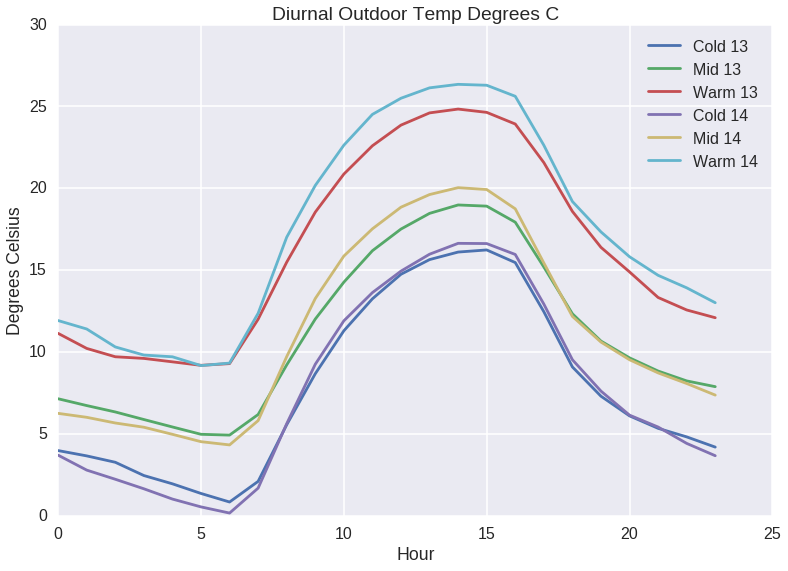

In [58]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'Temperature_(degC)'))         
      
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.title('Diurnal Outdoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')
plt.show()

#### Indoor Temperature

Indoor temperature looks to follow similar trends but the years differ, especially in the later hours of cold days. 2014 stays warmer overnight on both cold and warm days. We can also comment out the plot command for any dataframe if we want to isolate a particular subset of dataframes (ie just the 2013 days or just the cold days)

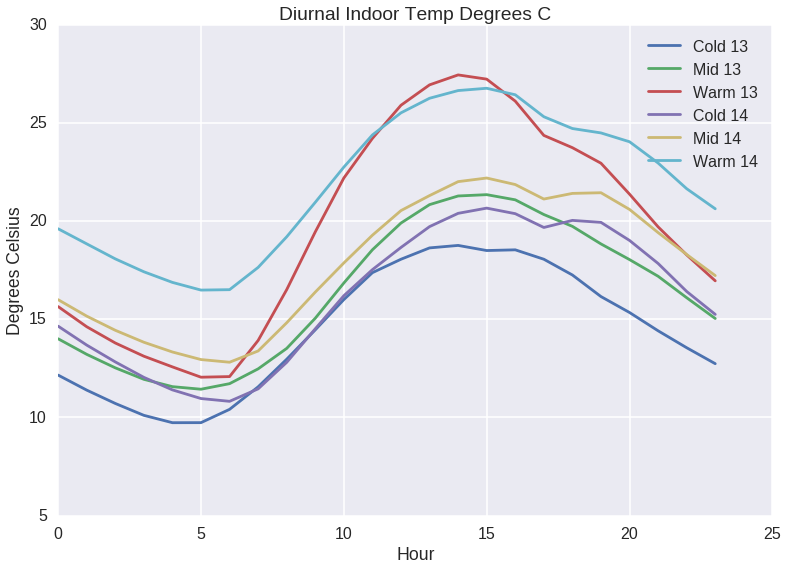

In [59]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'AvgHouse'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'AvgHouse'))         
      
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.title('Diurnal Indoor Temp Degrees C')
plt.xlabel('Hour')
plt.ylabel('Degrees Celsius')

plt.show()



#### Indoor/Outdoor Temperature Difference

We can isolate different subsets of temperature difference by commenting out the plot commands for unwanted subsets of data here as well. Again, we see that cold days in 2014 are greatly warmer inside than outside, and this generally holds true for all 2014 data when compared to its 2013 counterparts. 

The derivative plot still shows a large derivative in the evening spike, so it's likely KwaDela residents are still using the stove about the same amount for cooking dinner, but they are kept warmer/don't lose heat as quickly. The intervention at least keeps people well insulated

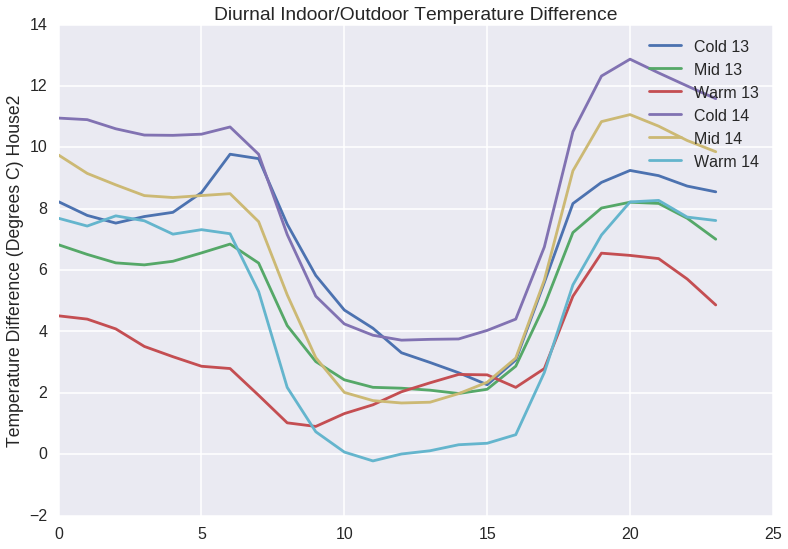

In [60]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'tempdifference'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'tempdifference'))
plt.title('Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

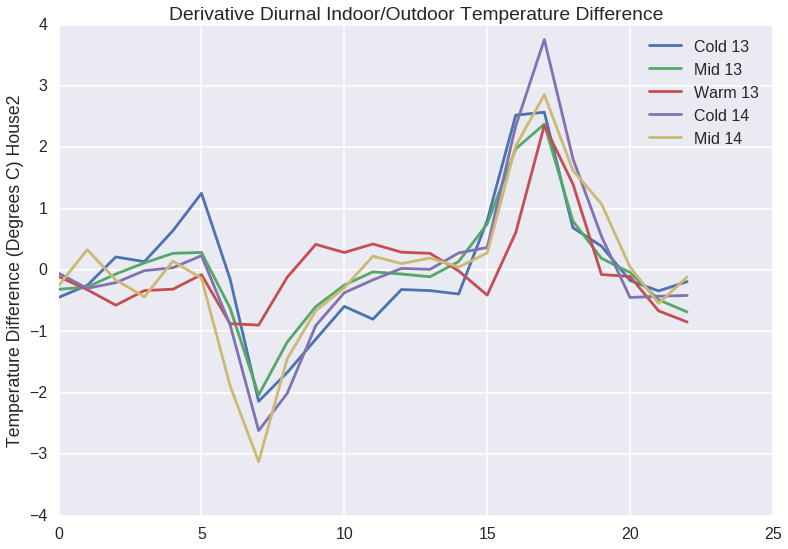

In [61]:
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013cold, 'tempdifference')))
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013mid, 'tempdifference')))
plt.plot(hourlist23, np.diff(featurediurnaldata(df2013warm, 'tempdifference')))
plt.plot(hourlist23, np.diff(featurediurnaldata(df2014cold, 'tempdifference')))
plt.plot(hourlist23, np.diff(featurediurnaldata(df2014warm, 'tempdifference')))
plt.title('Derivative Diurnal Indoor/Outdoor Temperature Difference')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('Temperature Difference (Degrees C) House2') 
plt.show()

#### PM4 

The warm 2014 morning spike is unreasonably high, which warrants inspection of data collection methods that may have faulted in warmer temperatures. The mid days of 2014 also exhibt high PM4 concentrations, which warrants investigation of the collected data and the intervention itself.

Cold days of 2014, however,exhibit a record-low morning spike, potentially demonstrating the lack of morning burning. 

The dinner spike still seems to show that 2014 data has comparable or greater PM4 concentrations, so it's likely the intervention did not change traditional cooking of dinner with the coal stove. The intervention may have also reduced ventilation of pollutants through increased insullation.

As with the past visualizations, we've commented out certain subsets of data to compare like sets.

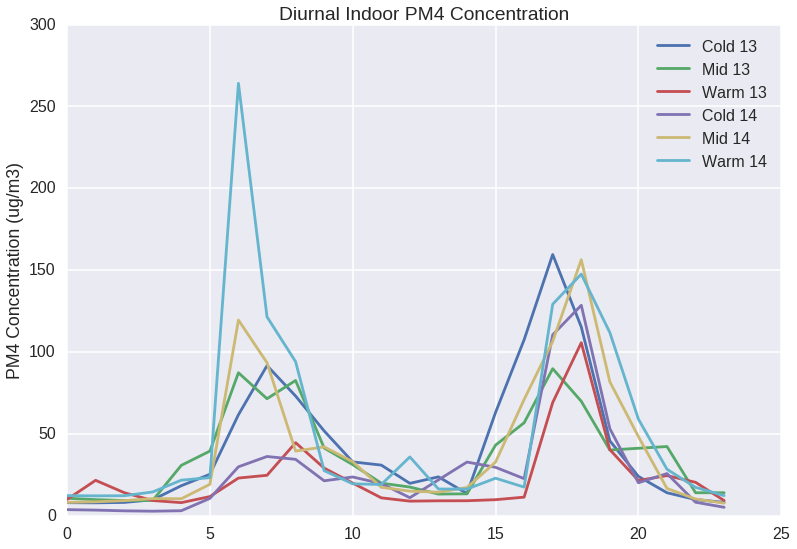

In [62]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM4_(ug/m3)'))
plt.title('Diurnal Indoor PM4 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM4 Concentration (ug/m3)') 
plt.show()


#### PM10
*Needs to be examined more, I'm not really sure what's going on -mack


Cold 2014 days seemed to have the least pollution, but trends are hard to etablish here in general

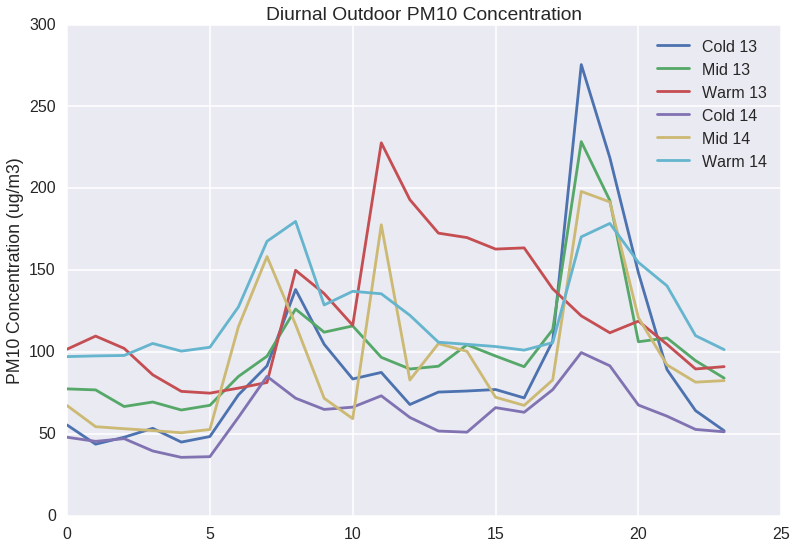

In [63]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM10_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM10_(ug/m3)'))
plt.title('Diurnal Outdoor PM10 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM10 Concentration (ug/m3)') 
plt.show()


#### PM2.5

PM2.5 shows the most clear change in 2014, as every 2014 dataset shows a lower concentration than its counterpart, with few exceptions. The evening spike is reduced in 2014, which is interesting given that stoves appear to still be used for cooking. This may be an artifact of greater coal use to heat and cook simultaneously in 2013, whereas in 2014 the stove was primarily a cooking instrument.

Warm days of 2013 also have abnormally high afternoon PM2.5 concentrations, which may be due to systematic error, or presence of another outdoor pollutant during warm days that year. 

Subsets of data may be isolated on the graph by commenting out unwanted plots.

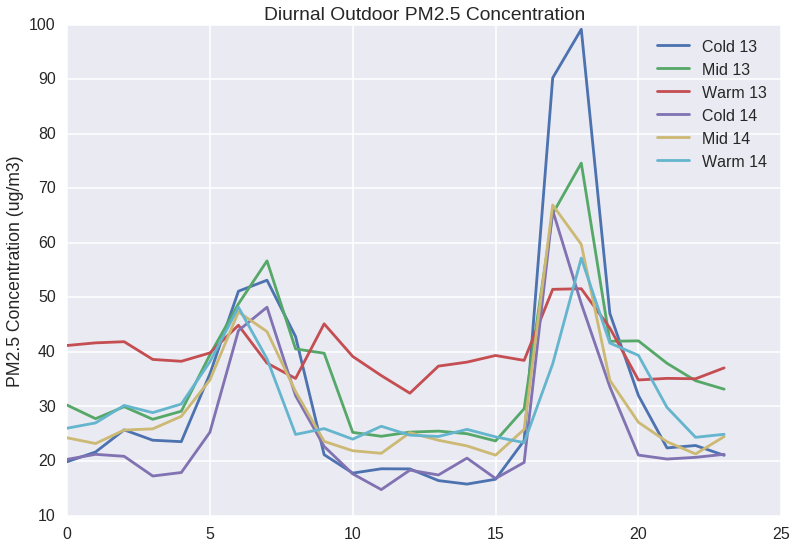

In [64]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'PM2.5_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'PM2.5_(ug/m3)'))
plt.title('Diurnal Outdoor PM2.5 Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('PM2.5 Concentration (ug/m3)') 
plt.show()

#### CO

CO data is mostly unusable for comparisons between the two years, as shown by the massive spike in warm days of 2013 at midnight. The 2013 data renders the first graph unusable.

The 2014 CO graph is useful for tracing burning between the three groupings of days, but on the whole, CO data is inconclusive. 

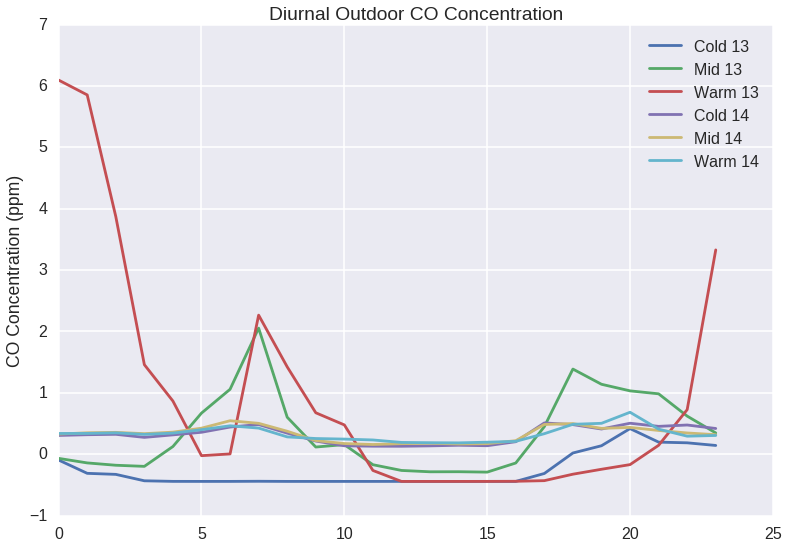

In [65]:
plt.plot(hourlist, featurediurnaldata(df2013cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2013mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2013warm, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'CO_(ppm)'))
plt.title('Diurnal Outdoor CO Concentration')
plt.legend(['Cold 13', 'Mid 13', 'Warm 13', 'Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


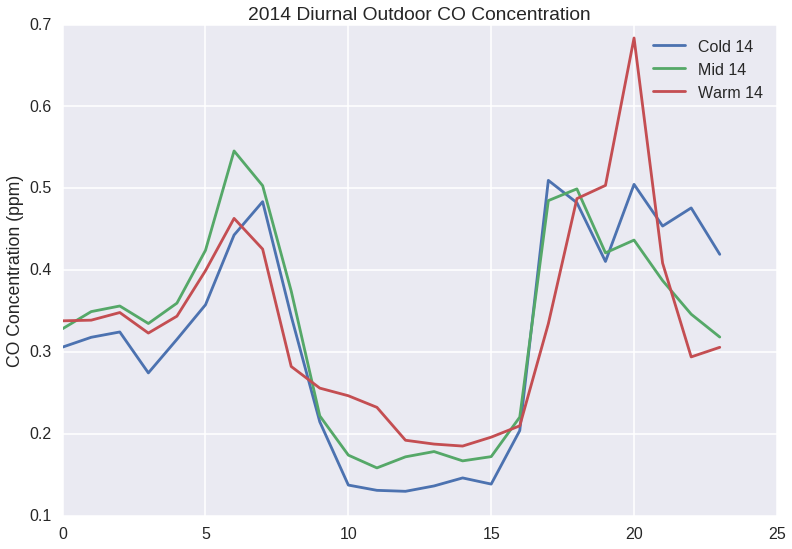

In [66]:
plt.plot(hourlist, featurediurnaldata(df2014cold, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014mid, 'CO_(ppm)'))
plt.plot(hourlist, featurediurnaldata(df2014warm, 'CO_(ppm)'))
plt.title('2014 Diurnal Outdoor CO Concentration')
plt.legend(['Cold 14', 'Mid 14', 'Warm 14'])
plt.ylabel('CO Concentration (ppm)') 
plt.show()


### We explored splitting the dataframes up by time of day.

There are evidently two main peaks of stove activity in a given day- one in the morning where water is boiled for tea and the house is warmed from a cold night, and one in the evening during which dinner is cooked and the house is warmed (slightly). It's useful to isolate these behaviors. 

#### The graphs below are helpful in visualizing what each time bracket is.  
A, C, and E are the baseline, either middle of the day or middle of the night, when people aren't burning.
B is the morning when people get up, make tea, and heat up their homes.
D is the evening when people make dinner.

These graphs mostly illustrate the concept of breaking data into time periods, since we've already looked at these full graphs earlier. These divisions are useful for statistical comparisons to come

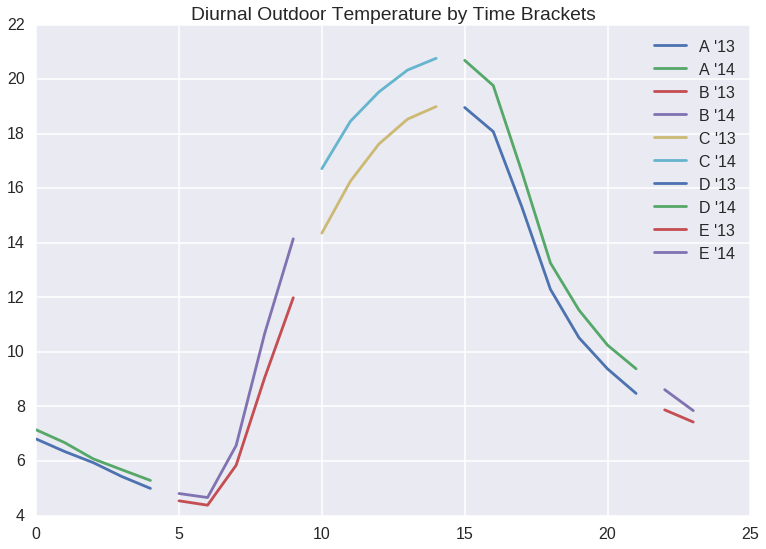

In [67]:
[df2013A, df2013B, df2013C, df2013D, df2013E] = abcdeTimeDataframes(df2013)
[df2014A, df2014B, df2014C, df2014D, df2014E] = abcdeTimeDataframes(df2014)


plt.plot(hourlist, featurediurnaldata(df2013A, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014A, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013B, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014B, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013C, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014C, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013D, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014D, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2013E, 'Temperature_(degC)'))
plt.plot(hourlist, featurediurnaldata(df2014E, 'Temperature_(degC)'))
plt.legend(["A '13", "A '14", "B '13", "B '14", "C '13", "C '14", "D '13", "D '14", "E '13", "E '14" ])
plt.title('Diurnal Outdoor Temperature by Time Brackets')
plt.show()

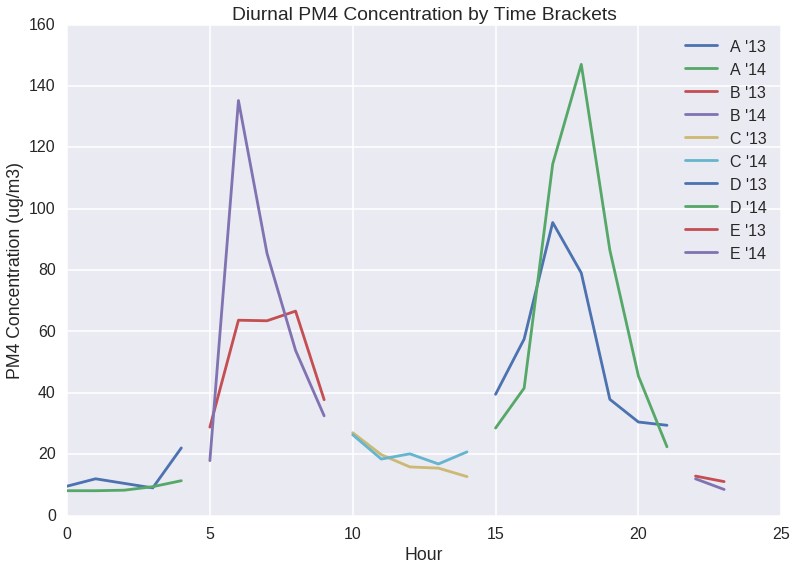

In [68]:
plt.plot(hourlist, featurediurnaldata(df2013A, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014A, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013B, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014B, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013C, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014C, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013D, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014D, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2013E, 'PM4_(ug/m3)'))
plt.plot(hourlist, featurediurnaldata(df2014E, 'PM4_(ug/m3)'))
plt.legend(["A '13", "A '14", "B '13", "B '14", "C '13", "C '14", "D '13", "D '14", "E '13", "E '14" ])
plt.title('Diurnal PM4 Concentration by Time Brackets')
plt.xlabel('Hour')
plt.ylabel('PM4 Concentration (ug/m3)')
plt.show()

# STATISTICAL COMPARISIONS

The trends of the graphs are great, but we need statistically significant quantitative data to understand just how different, or similar, 2013 and 2014 are.

## Kruskal Analysis 

Right now, we're looking at a Kruskal Wallis-H test, or one way analysis of variance on ranks, between 2014 and 2013 to see how significantly the data between years differed (this test is found in scipy.stats' kruskal method: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.stats.kruskal.html). We're looking at how the outdoor temperatures varied (as a soft control), and then comparing the years's pollutant concentrations to get a read for how well the intervention reduced pollution. We do this again with diurnal plots to be sure. 

Kruskal is best for comparing two or more series' with one category of measurement at different time points to see if there is significant variance between those groups. It's parametric, and uses ranked means to measure how greatly the series' differ. For example: Krusal done on dusttraks from the cold bracket, dusttraks from the warm bracket, and dusttraks from the mid bracket. This measurement tells us if there is variance in pollution between the three groups. This test can also be applied to 2013 vs 2014 dusttraks to find statistical significance in the differences in pollution before and after intervention. 

The null hypothesis of the Kruskal test states that the mean ranks of the compared two or more series' are the same. We are using a cutoff p-value of 0.05, so any test that returns a value lower than 0.05 shows that the series' are significantly different. 

#### Outdoor Temperature

Interestingly, when we compare different time brackets within a given year, the Kruskal test shows they are statistically not the same. The 0 p-values we encounter show either that the two compared series' are in no way alike, or there is not enough data to make an actual measurement. Given the size of the Kruskal statistic, the first option is more likely

When we compare the hourly sections by year, sections A,B, D, and E pass our threshold and are significantly different. This means that the outdoor temperatures can't be considered the same when considering each year's average winter day. Any variation in outdoor temperature is due to something other than chance, with the exception of section C, the midday temperature. Basing comparisons on these times brackets doesn't seem like a good idea.

In [69]:
print('2013:')
print ('A vs B')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013B['Temperature_(degC)'])
print ('A vs C')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013C['Temperature_(degC)'])
print ('A vs D')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('A vs E')
print stats.kruskal(df2013A['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('B vs C')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013C['Temperature_(degC)'])
print ('B vs D')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('B vs E')
print stats.kruskal(df2013B['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('C vs D')
print stats.kruskal(df2013C['Temperature_(degC)'], df2013D['Temperature_(degC)'])
print ('C vs E')
print stats.kruskal(df2013C['Temperature_(degC)'], df2013E['Temperature_(degC)'])
print ('D vs E')
print stats.kruskal(df2013D['Temperature_(degC)'], df2013E['Temperature_(degC)'])


print('')
print('2014')
print ('A vs B')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014B['Temperature_(degC)'])
print ('A vs C')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('A vs D')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('A vs E')
print stats.kruskal(df2014A['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('B vs C')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('B vs D')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('B vs E')
print stats.kruskal(df2014B['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('C vs D')
print stats.kruskal(df2014C['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('C vs E')
print stats.kruskal(df2014C['Temperature_(degC)'], df2014E['Temperature_(degC)'])
print ('D vs E')
print stats.kruskal(df2014D['Temperature_(degC)'], df2014E['Temperature_(degC)'])

2013:
A vs B
KruskalResult(statistic=242.36573583120639, pvalue=1.1991674572957914e-54)
A vs C
KruskalResult(statistic=15270.320913598514, pvalue=0.0)
A vs D
KruskalResult(statistic=11094.903190621222, pvalue=0.0)
A vs E
KruskalResult(statistic=620.04055073571988, pvalue=7.3271910777861924e-137)
B vs C
KruskalResult(statistic=12331.220036531144, pvalue=0.0)
B vs D
KruskalResult(statistic=6638.677234465049, pvalue=0.0)
B vs E
KruskalResult(statistic=18.173190667393019, pvalue=2.016982237069756e-05)
C vs D
KruskalResult(statistic=5056.3628836190637, pvalue=0.0)
C vs E
KruskalResult(statistic=9696.6871434795612, pvalue=0.0)
D vs E
KruskalResult(statistic=4977.6297028138952, pvalue=0.0)

2014
A vs B
KruskalResult(statistic=1151.7167179543976, pvalue=1.9001299129319651e-252)
A vs C
KruskalResult(statistic=29255.570493988242, pvalue=0.0)
A vs D
KruskalResult(statistic=20794.793448696597, pvalue=0.0)
A vs E
KruskalResult(statistic=1287.554111955254, pvalue=5.726610957213861e-282)
B vs C
Krusk

In [70]:
 
print('2013 vs 2014')
print ('A')
print stats.kruskal(df2013A['Temperature_(degC)'], df2014A['Temperature_(degC)'])
print ('B')
print stats.kruskal(df2013B['Temperature_(degC)'], df2014B['Temperature_(degC)'])
print ('C')
print stats.kruskal(df2013C['Temperature_(degC)'], df2014C['Temperature_(degC)'])
print ('D')
print stats.kruskal(df2013D['Temperature_(degC)'], df2014D['Temperature_(degC)'])
print ('E')
print stats.kruskal(df2013E['Temperature_(degC)'], df2014E['Temperature_(degC)'])

2013 vs 2014
A
KruskalResult(statistic=811.26807165503942, pvalue=1.9151409789060449e-178)
B
KruskalResult(statistic=423.56903055839859, pvalue=4.0795502265722341e-94)
C
KruskalResult(statistic=3.1139733181302316, pvalue=0.077623383568087775)
D
KruskalResult(statistic=464.0996145871365, pvalue=6.1624418293675769e-103)
E
KruskalResult(statistic=227.01060383265539, pvalue=2.674842547934165e-51)


### Without time brackets - Compare cold days

We're comparing theh 2013 and 2014 cold days dataframes, starting with our different ways to measure outdoor temperature. Taking individual data points from Temperature\_(degC) shows that the two years are pretty significantly different in outdoor temperature, and the variation in temperature is probably not due to chance. When we compare DailyAverageTemp(which smooths out the daily periodic behavior of temperature) we find 2013 and 2014 are even more significantly different than when we compare the raw Temperature\_(degC) series'.

The average diurnal profiles of each year's outdoor temperature, which we get with the featurediurnaldata function, are not at all significantly different. In fact, we can accept the null hypothesis with 95% certainty. If we see other features from diurnal profiles that are statistically significantly different, we know these differences probably aren't a result of outdoor temperature fluctuation (looking at indoor temperature especially). 

Indoor/Outdoor Temperature Difference IS significantly different between years for the cold day diurnal profiles.
From this p-value we have enough evidence to reject the null hypothesis that variation is not due to chance. We can confidentally say that the homes are warmer because of the intervention.

In [71]:
#Every Temp data point
stats.kruskal(df2013cold['Temperature_(degC)'], df2014cold['Temperature_(degC)'])

KruskalResult(statistic=7.6919374454515763, pvalue=0.0055468050870174845)

In [72]:
#Daily Averages
stats.kruskal(df2013cold.DailyAverageTemp, df2014cold.DailyAverageTemp)

KruskalResult(statistic=60.612370079061677, pvalue=6.949592412673137e-15)

In [73]:
#Diurnal Profile
stats.kruskal(featurediurnaldata(df2013cold, 'Temperature_(degC)'), featurediurnaldata(df2014cold, 'Temperature_(degC)'))

KruskalResult(statistic=0.0038265306122298171, pvalue=0.95067515211034936)

In [74]:
stats.kruskal(featurediurnaldata(df2013cold, 'tempdifference'),featurediurnaldata(df2014cold, 'tempdifference'))

KruskalResult(statistic=5.051445578231295, pvalue=0.024605401927148121)

### Pollutant Cold Day Comparisons
The p-value when comparing PM4 is not low enough to say outright that the PM4 values per year are different. It's low enough that we can probably conclude that PM4 is different, but because it doesn't reach our cutoff there's still about a 17% chance any variation we observe in PM4 is due to chance. 

PM10 IS significantly different between years for the cold day diurnal profiles.
From this p-value we have enough evidence to reject the null hypothesis and conclude that 2014 definitely had PM10 concentrations different from the PM10 of 2013

For PM2.5, we do not have enough certainty to reject the null hypothesis. The PM2.5 concentrations may still be statistically equal in 2013 and 2014.

CO concentration IS significantly different between years for the cold day diurnal profiles.
From this p-value we have enough evidence to reject the null hypothesis, but because 2013 CO data was declared unusable, this value doesn't mean anything until we have accurate CO 2013 data.

In [75]:
#PM4
stats.kruskal(featurediurnaldata(df2013cold, 'PM4_(ug/m3)'), featurediurnaldata(df2014cold, 'PM4_(ug/m3)'))

KruskalResult(statistic=1.9659863945578309, pvalue=0.16087452877075625)

In [76]:
#PM10
stats.kruskal(featurediurnaldata(df2013cold, 'PM10_(ug/m3)'), featurediurnaldata(df2014cold, 'PM10_(ug/m3)'))

KruskalResult(statistic=6.3282312925170174, pvalue=0.011883077001124228)

In [77]:
#PM2.5
stats.kruskal(featurediurnaldata(df2013cold, 'PM2.5_(ug/m3)'), featurediurnaldata(df2014cold, 'PM2.5_(ug/m3)'))

KruskalResult(statistic=1.5820578231292473, pvalue=0.208464529537846)

In [78]:
stats.kruskal(featurediurnaldata(df2013cold, 'CO_(ppm)'), featurediurnaldata(df2014cold, 'CO_(ppm)'))

KruskalResult(statistic=26.867804515098726, pvalue=2.1785802291328526e-07)

## Correlation Matricies 

Spearman's rank correlation lets us track how well each series' trends correlate with one another (this is done in a matrix representation). We pick a spearman correlation because it doesn't rely on the parameters a perason's correlation does. The pandas method dataframe.corr lets us pick spearman, ignores nans (a must have) and constructs a useful dataframe of correlation coefficients that just make the whole matrix process a lot less painful.

In [109]:
def normalize(df, headers):
    """Normalizes values of a dataframe, ignoring Nans. Should only be used on test quantities
    df: dataframe of un-normalized integer only data
    headers: specifc columns to be compared to one another
    returns: now normalized dataframe of only the specified headers with missing values filled in"""
    normdf = df[headers]
    df_norm = (normdf-normdf.mean())/(normdf.max() - normdf.min())
    return df_norm

intHeadCorrList= [ 'Temperature_(degC)','PM4_(ug/m3)', 'PM10_(ug/m3)','PM2.5_(ug/m3)','SO2_(ppb)','CO_(ppm)','NO_(ppb)',
                 'NO2_(ppb)','AvgHouse']
#plt.plot(df2013[intHeadCorrList[0:1]].isnull().mean(axis=1))#check how many nans are in a series if wanted
dfnorm13 = normalize(df2013, intHeadCorrList)
dfnorm14 = normalize(df2013, intHeadCorrList)

In [110]:
speardf13 = dfnorm13.corr(method = 'spearman')
speardf14 = dfnorm14.corr(method = 'spearman')

The correlation dataframe generation works, so we now make a heatmap for the correlation constants on a scale from 1 to -1. the code for the heatmap actually comes from https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html


Correlations seem generally the same across years, so we look more at differences between temperature brackets. 

In [111]:
def correlationHeatmap(corrmat, year = ''):
    """Constructs a heatmap correlation matrix
    corrmat: dataframe of correlation constants
    year: year to which data applies"""
#set up mask to cover upper triangle of the matrix 
    mask = np.zeros_like(speardf, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
    sns.heatmap(corrmat,mask=mask, vmax=.8, square=True)

    plt.title('Winter of '+ year+ ' Temperature and Pollutant Correlations')
    plt.xticks(rotation=30)
    f.tight_layout()

2013:
This heat map shows a negative correlation between temperature and CO, strong positive correlations between Indoor and Outdoor temperature, between SO2 and NO2, between NO and NO2, positive correlations between SO2 and NO, PM10 and SO2, PM10 and NO2, PM4 and PM10, PM4 and NO, and outdoor temperature and SO2.

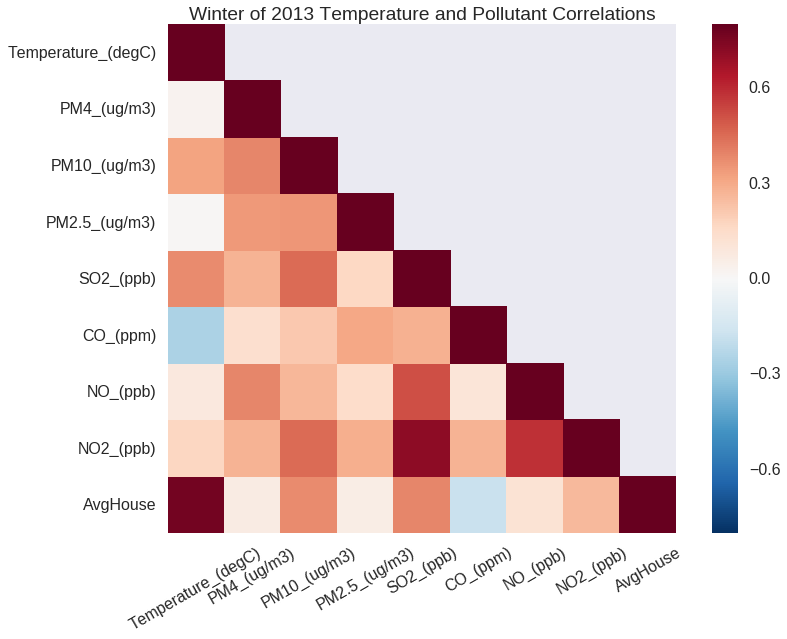

In [112]:
#2013 on the whole
correlationHeatmap(speardf13, '2013')

2014:
Similarly to 2013, this heat map shows a negative correlation between temperature and CO, strong positive correlations between indoor and outdoor temperatures, between SO2 and NO2, between NO and NO2, positive correlations between SO2 and NO, PM10 and SO2, PM10 and NO2, PM4 and PM10, PM4 and NO, and outdoor temperature and SO2.

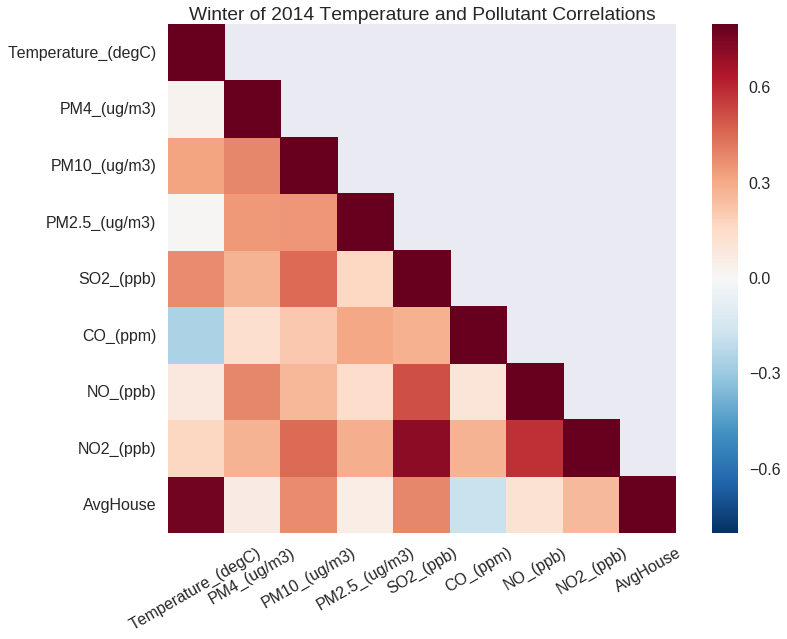

In [113]:
#2014 on the whole 
correlationHeatmap(speardf14, '2014')

2013 Warm Days: This heat map shows a negative correlation between outdoor temperature and CO as well as between indoor temperature and CO, strong positive correlations between indoor and outdoor temperatures, between SO2 and NO2, between NO and NO2, between outdoor temperature and PM10, positive correlations between SO2 and NO, PM10 and SO2,  PM4 and PM10, and outdoor temperature and SO2.

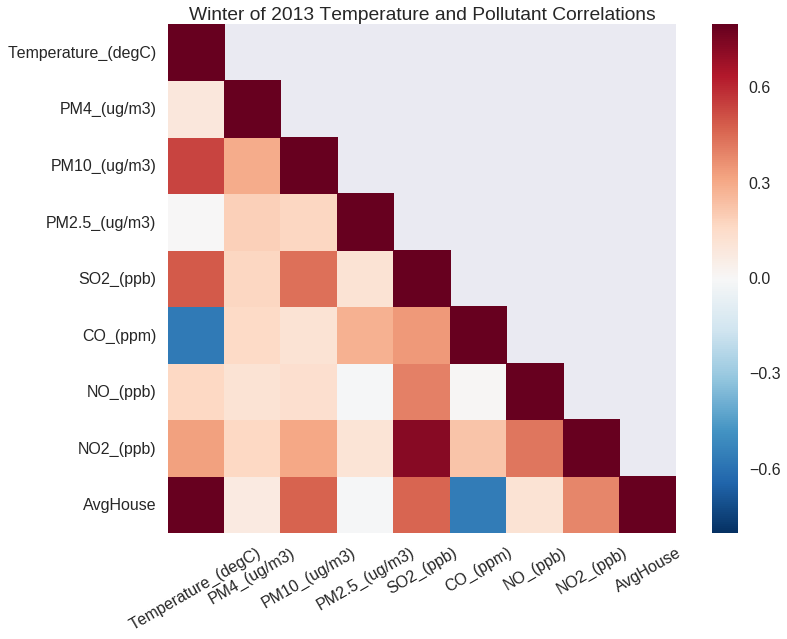

In [114]:
#warm 2013 range
dfnormwarm13 = normalize(df2013warm, intHeadCorrList)
speardfwarm13 = dfnormwarm13.corr(method = 'spearman')
correlationHeatmap(speardfwarm13, '2013')

2013 Cold Days: This heat map shows a negative correlation between temperature and CO, strong positive correlations between indoor and outdoor temperatures, between SO2 and NO, between SO2 and NO2, between NO and NO2, between PM4 and PM10, positive correlations between SO2 and CO, PM10 and SO2, PM10 and NO, PM4 and NO, PM4 and PM2.5, and outdoor temperature and SO2.

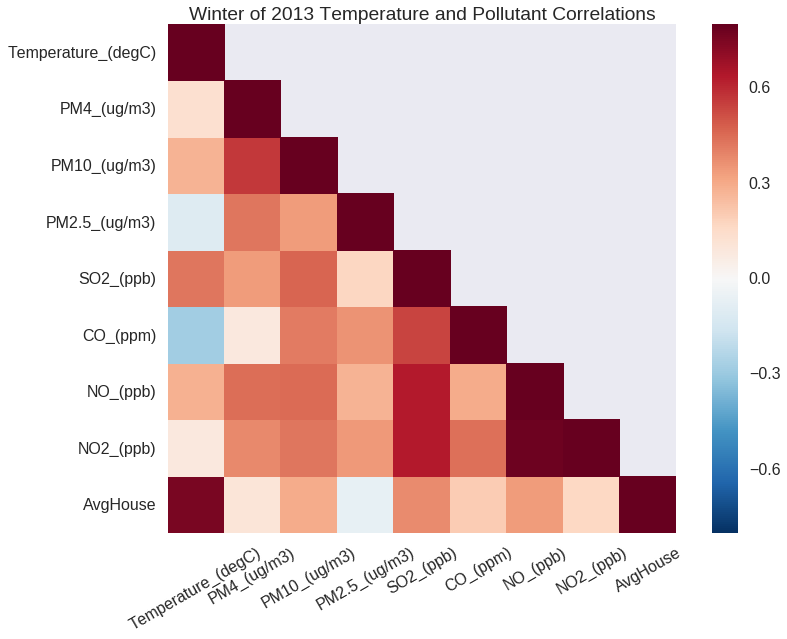

In [115]:
#cold 2013 range
dfnormcold13 = normalize(df2013cold, intHeadCorrList)
speardfcold13 = dfnormcold13.corr(method = 'spearman')
correlationHeatmap(speardfcold13, '2013')

2014 Warm Days: This heat map shows a negative correlation between temperature and CO as well as between outdoor temperature and PM4, strong positive correlations between indoor and outdoor temperatures, between SO2 and NO2,between SO2 and NO, between NO and NO2,  positive correlations between PM10 and SO2, PM10 and NO2,CO and NO2 and outdoor temperature and SO2.

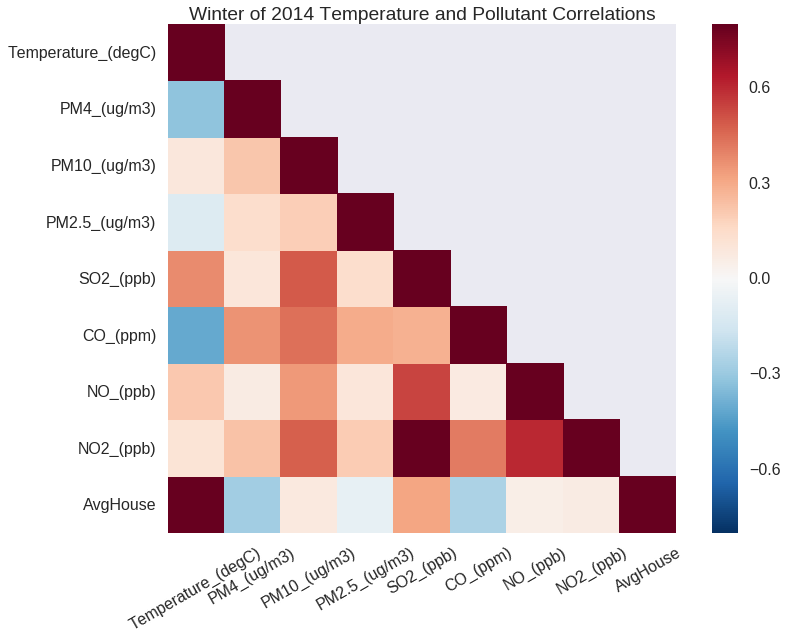

In [116]:
#warm 2014
dfnormwarm14 = normalize(df2014warm, intHeadCorrList)
speardfwarm14 = dfnormwarm14.corr(method = 'spearman')
correlationHeatmap(speardfwarm14, '2014')

2014 Cold Days: This heat map shows strong positive correlations between indoor and outdoor temperatures, between CO and NO2, between NO and NO2, between SO2 and NO2,  and positive correlations between SO2 and NO,  PM4 and PM10, PM2.5 and CO, PM2.5 and NO2.

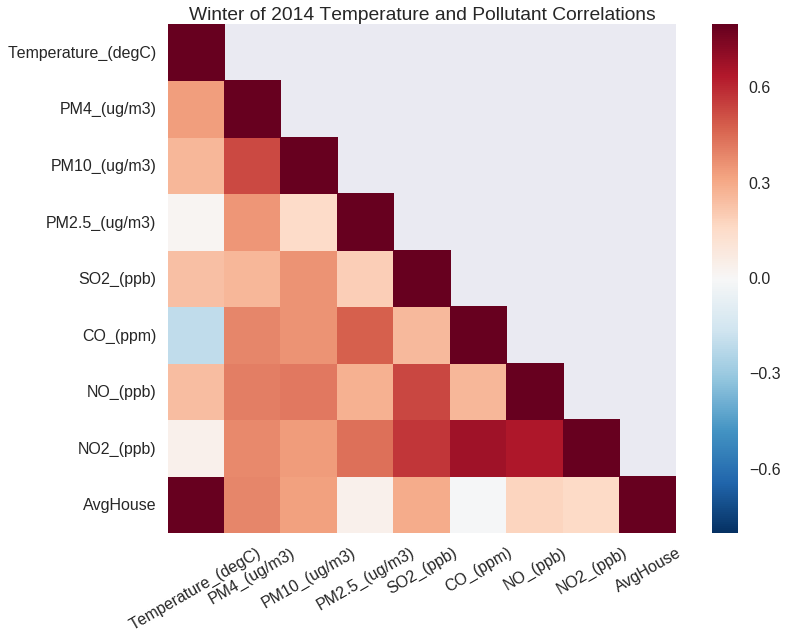

In [117]:
#cold 2014
dfnormcold14 = normalize(df2014cold, intHeadCorrList)
speardfcold14 = dfnormcold14.corr(method = 'spearman')
correlationHeatmap(speardfcold14, '2014')